ALGÈBRES AIMABLES

Une algèbre aimable $A = kQ/I$ est l'algèbre d'un carquois $Q$ avec relations $I$ tels que :
   - $I$ est engendré par des chemins de longueur 2,
   - tout sommet est incident à au plus 2 flèches entrantes et 2 flèches sortantes,
   - pour toute flèche $\beta$, il y a au plus une flèche $\alpha$ telle que $\alpha\beta \in I$ (resp. telle que $\alpha\beta \notin I$),
   - pour toute flèche $\beta$, il y a au plus une flèche $\gamma$ telle que $\beta\gamma \in I$ (resp. telle que $\beta\gamma \notin I$).

In [53]:
load('gentleAlgebras.sage')

In [46]:
Q1 = BoundQuiver({'e1':{'e2':['a','b']}, 'e2':{'e3':['c']}}, [])

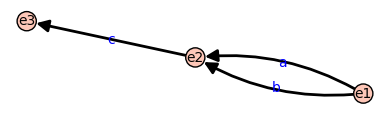

In [33]:
Q1.show()

In [24]:
Q1.quiver_paths()

[['b'], ['b', 'c'], ['a'], ['a', 'c'], ['c']]

In [54]:
Q1 = GentleQuiver({'e1':{'e2':['a','b']}, 'e2':{'e3':['c']}}, [('a','c')])
Q2 = GentleQuiver({'e1':{'e3':'a'}, 'e2':{'e3':'c'}, 'e3':{'e4':'b', 'e5':'d'}}, [('a','b'),('c','d')])
Q3 = GentleQuiver({'e1':{'e2':['a','b']}}, [])

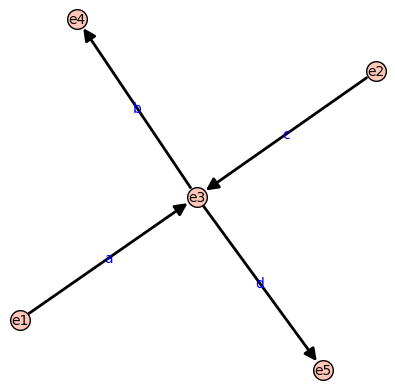

In [26]:
Q2.show()

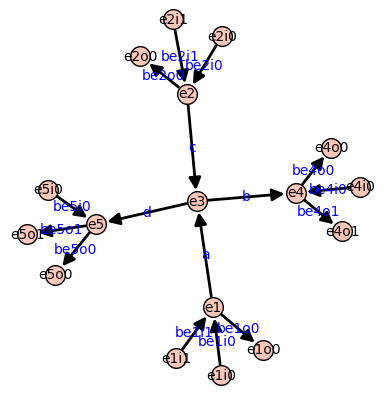

[('a', 'b'),
 ('c', 'd'),
 ('be1i0', 'be1o0'),
 ('be1i1', 'a'),
 ('be2i0', 'be2o0'),
 ('be2i1', 'c'),
 ('b', 'be4o1'),
 ('be4i0', 'be4o0'),
 ('d', 'be5o1'),
 ('be5i0', 'be5o0')]

In [27]:
Q2b = Q2.blossomingQuiver()
Q2b.show()
Q2b.ideal()

In [55]:
Q2.blossoming_quiver_walks()

[['be5i0', 'd-', 'a-', 'be1o0'],
 ['be5i0', 'd-', 'a-', 'be1i0-'],
 ['be5i0', 'd-', 'b', 'be4o0'],
 ['be5i0', 'd-', 'b', 'be4i0-'],
 ['be5i0', 'be5o1'],
 ['be1i0', 'a', 'c-', 'be2o0'],
 ['be1i0', 'a', 'c-', 'be2i0-'],
 ['be1i0', 'a', 'd', 'be5o0'],
 ['be1i0', 'a', 'd', 'be5i0-'],
 ['be1i0', 'be1i1-'],
 ['be2i0', 'be2i1-'],
 ['be4i0', 'be4o1']]

In [52]:
RecursivelyEnumeratedSet?